![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/10.1.Data_Augmentation_with_ChunkMappers_Edgar.ipynb)

# Financial Data Augmentation with Chunk Mappers

**This notebook is the continuation of [10.0.Data_Augmentation_with_ChunkMappers.ipynb](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Finance/10.0.Data_Augmentation_with_ChunkMappers.ipynb)**

# Installation

In [ ]:
! pip install -q johnsnowlabs

## Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, finance

# nlp.install(force_browser=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

Please Upload your John Snow Labs License using the button below


Saving spark_nlp_for_healthcare_spark_ocr_6538.json to spark_nlp_for_healthcare_spark_ocr_6538 (1).json


- Install it

In [ ]:
nlp.install()

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_6538.json
👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_6538.json
👌 JSL-Home is up to date! 
👌 Everything is already installed, no changes made


# Starting

In [ ]:
spark = nlp.start()

Spark Session already created, some configs may not take.
👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_6538.json


## Step 3: Matching our NER to the Chunk Mappers data source

Let's suppose we want to manually get information about CADENCE DESIGN SYSTEMS, INC.

Since it's a public US company, we can go to [SEC Edgar's database](https://www.sec.gov/edgar/searchedgar/companysearch) and look for it.

Unfortunately, `CADENCE DESIGN SYSTEMS, INC` is not the official name of the company, which means no entry for `CADENCE DESIGN SYSTEMS, INC` is available. 

This happens very often. Data providers may have different versions of the name with different punctuation. For example, for Meta:
- Meta Platforms, Inc.
- Meta Platforms Inc.
- Meta Platforms, Inc
- etc

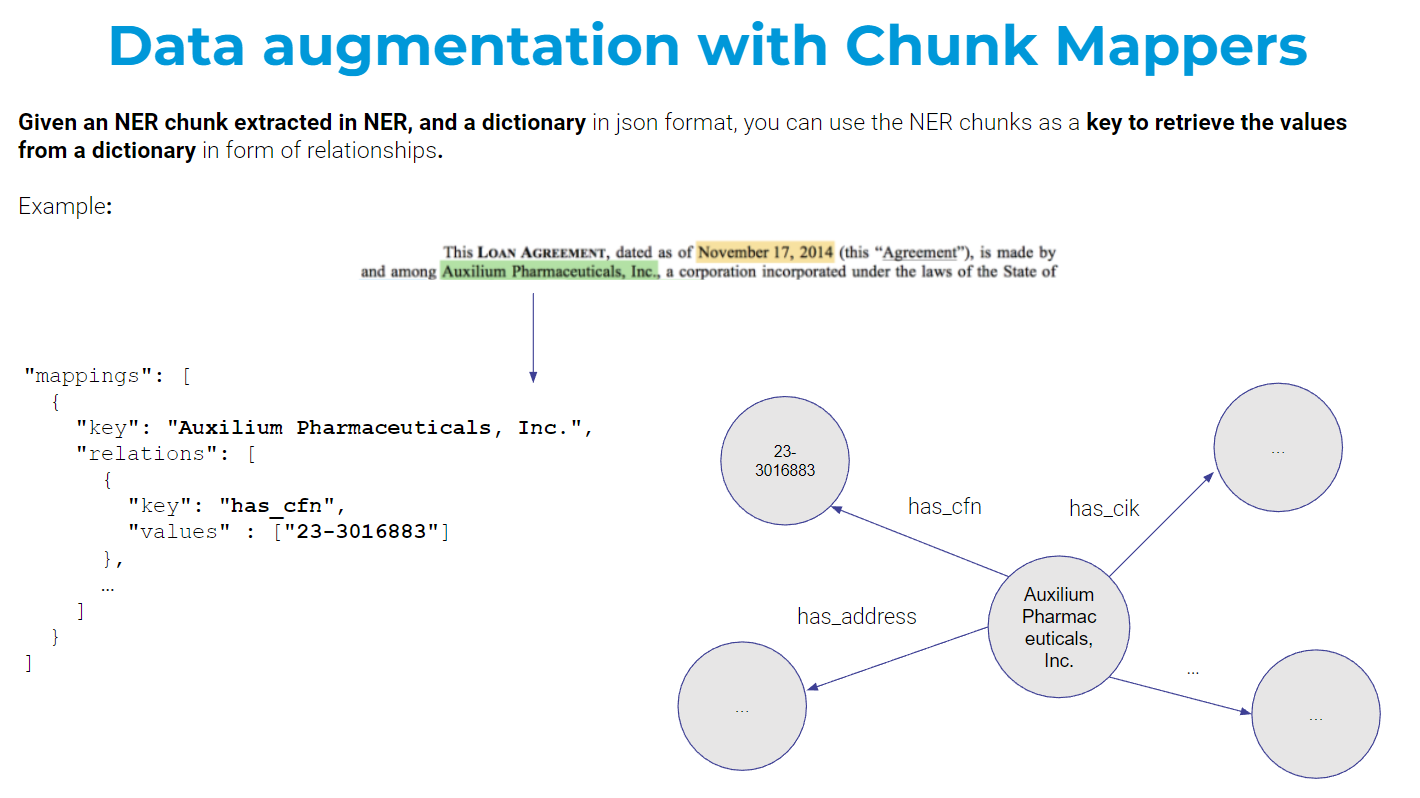


ChunkMappers work by default with `EXACT MATCHES`. So if you don't extract exactly the very same way the company appears in your ChunkMapper, you won't get any result. But evidently we include 2 ways to cope with non-full matches.

1. First, using Chunk Mappers **Fuzzy Matching** (Section 3a).
2. Second, using **Entity Resolvers to Normalize** or Map the name of the company extracted in NER to the name which appears in our Chunk Mapper (Section 2b).

In this case, we will use Edgar Database (`finmapper_edgar_companyname`)

The component which carries out __Data Augmentation__ is called `ChunkMapper`.

It's name comes from the way it works: it uses a _Ner Chunk_ to map it to an external data source.

As a result, you will get a JSON with a dictionary of additional fields and their values. 

Let's take a look at how it works.

## Step 3a: Using Fuzzy Matching

Let's use our NER chunk to map it to Edgar ChunkMapper using Fuzzy Matching.

In [ ]:
ORG = ['CADENCE DESIGN SYSTEMS, INC', 'CADENCE DESIGN SYSTEM INCORPORATED']

ORG

['CADENCE DESIGN SYSTEMS, INC', 'CADENCE DESIGN SYSTEM INCORPORATED']

In [ ]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# Posible distance metrics: ['levenshtein', 'longest-common-subsequence', 'cosine']
CM = finance.ChunkMapperModel().pretrained("finmapper_edgar_companyname", "en", "finance/models")\
    .setInputCols(["document"])\
    .setOutputCol("mappings")\
    .setEnableFuzzyMatching(True)\
    .setEnableCharFingerprintMatching(False)\
    .setFuzzyMatchingDistances(['cosine'])\
    .setFuzzyMatchingDistanceThresholds([0.1])

cm_pipeline = nlp.Pipeline(stages=[document_assembler, CM])

empty_data = spark.createDataFrame([[""]]).toDF("text")

fit_cm_pipeline = cm_pipeline.fit(empty_data)

lp = nlp.LightPipeline(fit_cm_pipeline)

res = lp.fullAnnotate(ORG)

finmapper_edgar_companyname download started this may take some time.
[OK!]


In [ ]:
for r in res:
  for map in r['mappings']:
    print(map)

Annotation(labeled_dependency, 0, 26, CADENCE DESIGN SYSTEMS INC, {'__trained__': 'CADENCE DESIGN SYSTEMS INC', 'relation': 'name', '__distance_function__': 'cosine', 'ops': '0.037037037037037035', 'all_relations': '', 'entity': 'CADENCE DESIGN SYSTEMS, INC', 'distance': '0.0', '__relation_name__': 'name'}, [])
Annotation(labeled_dependency, 0, 26, SERVICES-PREPACKAGED SOFTWARE [7372], {'__trained__': 'CADENCE DESIGN SYSTEMS INC', 'relation': 'sic', '__distance_function__': 'cosine', 'ops': '0.037037037037037035', 'all_relations': '', 'entity': 'CADENCE DESIGN SYSTEMS, INC', 'distance': '0.0', '__relation_name__': 'sic'}, [])
Annotation(labeled_dependency, 0, 26, 7372, {'__trained__': 'CADENCE DESIGN SYSTEMS INC', 'relation': 'sic_code', '__distance_function__': 'cosine', 'ops': '0.037037037037037035', 'all_relations': '0', 'entity': 'CADENCE DESIGN SYSTEMS, INC', 'distance': '0.0', '__relation_name__': 'sic_code'}, [])
Annotation(labeled_dependency, 0, 26, 770148231, {'__trained__': '

**We have been able to successfully retrieve the information in Edgar using different variations of the Company Name `CADENCE DESIGN SYSTEMS`!**

## Step 3b: Using Entity Resolvers for Company Names Normalization


In the previous step, with Fuzzy Matching, we don't really care what the official name of the company in Edgar is.

If we want to retrieve that information as well, we can first do an additional step: __Company Names Normalization__.

**Company Name Normalization** is the process of obtaining the name of the company used by data providers, usually the "official" name of the company (in their databases! it may be different in different data providers!)

Let's normalize `CADENCE DESIGN SYSTEMS, INC` to the official name in _SEC Edgar_.

In [ ]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

use_embeddings = nlp.UniversalSentenceEncoder.pretrained()\
    .setInputCols("document") \
    .setOutputCol("sentence_embeddings")
    
resolver = finance.SentenceEntityResolverModel.pretrained("finel_edgar_company_name", "en", "finance/models")\
      .setInputCols(["sentence_embeddings"]) \
      .setOutputCol("resolution")\
      .setDistanceFunction("EUCLIDEAN")

pipelineModel = nlp.PipelineModel(
      stages = [
          document_assembler,
          use_embeddings,
          resolver])

lp_res = nlp.LightPipeline(pipelineModel)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
finel_edgar_company_name download started this may take some time.
[OK!]


In [ ]:
el_res = lp_res.annotate(ORG)
el_res

[{'document': ['CADENCE DESIGN SYSTEMS, INC'],
  'sentence_embeddings': ['CADENCE DESIGN SYSTEMS, INC'],
  'resolution': ['CADENCE DESIGN SYSTEMS INC']},
 {'document': ['CADENCE DESIGN SYSTEM INCORPORATED'],
  'sentence_embeddings': ['CADENCE DESIGN SYSTEM INCORPORATED'],
  'resolution': ['CADENCE DESIGN SYSTEMS INC']}]

In [ ]:
NORM_ORG = el_res[0]['resolution'][0]

NORM_ORG

'CADENCE DESIGN SYSTEMS INC'

Here is our normalized name for Amazon: `CADENCE DESIGN SYSTEMS INC`.

Now, let's see which information is available in Edgar database for `CADENCE DESIGN SYSTEMS INC`

Once we have the normalized name of the company, we can use `John Snow Labs Chunk Mappers`. These are pretrained data sources, which are updated frequently and can be queried inside Spark NLP without sending any API call to any server.

In this case, we will use Edgar Database (`finmapper_edgar_companyname`)




### And now we use the normalized version from Edgar, instead of directly the entity text we obtained in NER, which is unnormalized

In [ ]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# Posible distance metrics: ['levenshtein', 'longest-common-subsequence', 'cosine']
CM = finance.ChunkMapperModel().pretrained("finmapper_edgar_companyname", "en", "finance/models")\
    .setInputCols(["document"])\
    .setOutputCol("mappings")\
    .setEnableFuzzyMatching(True)\
    .setEnableCharFingerprintMatching(False)\
    .setFuzzyMatchingDistances(['cosine'])\
    .setFuzzyMatchingDistanceThresholds([0.1])

cm_pipeline = nlp.Pipeline(stages=[document_assembler, CM])

empty_data = spark.createDataFrame([[""]]).toDF("text")

fit_cm_pipeline = cm_pipeline.fit(empty_data)

lp = nlp.LightPipeline(fit_cm_pipeline)

res = lp.fullAnnotate(NORM_ORG)

finmapper_edgar_companyname download started this may take some time.
[OK!]


In [ ]:
for r in res:
  for map in r['mappings']:
    print(map)

Annotation(labeled_dependency, 0, 25, CADENCE DESIGN SYSTEMS INC, {'__trained__': 'CADENCE DESIGN SYSTEMS INC', 'relation': 'name', '__distance_function__': 'levenshtein', 'ops': '0.0', 'all_relations': '', 'entity': 'CADENCE DESIGN SYSTEMS INC', 'distance': '0.0', '__relation_name__': 'name'}, [])
Annotation(labeled_dependency, 0, 25, SERVICES-PREPACKAGED SOFTWARE [7372], {'__trained__': 'CADENCE DESIGN SYSTEMS INC', 'relation': 'sic', '__distance_function__': 'levenshtein', 'ops': '0.0', 'all_relations': '', 'entity': 'CADENCE DESIGN SYSTEMS INC', 'distance': '0.0', '__relation_name__': 'sic'}, [])
Annotation(labeled_dependency, 0, 25, 7372, {'__trained__': 'CADENCE DESIGN SYSTEMS INC', 'relation': 'sic_code', '__distance_function__': 'levenshtein', 'ops': '0.0', 'all_relations': '0', 'entity': 'CADENCE DESIGN SYSTEMS INC', 'distance': '0.0', '__relation_name__': 'sic_code'}, [])
Annotation(labeled_dependency, 0, 25, 770148231, {'__trained__': 'CADENCE DESIGN SYSTEMS INC', 'relation'

Yes, here it is. We get additional information about `CADENCE DESIGN SYSTEMS INC` using only company name.